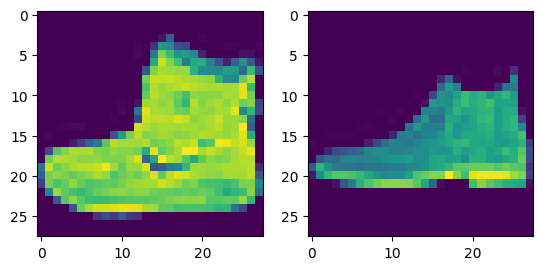

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

train_dataset = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
)

test_dataset = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(train_dataset.data[0])
fig.add_subplot(1,2,2)
plt.imshow(test_dataset.data[0])

In [2]:
torch.manual_seed(0)
train_dataloader = DataLoader(train_dataset,
    batch_size=256,
    shuffle=True
)

model_0_1 = nn.Sequential(
    nn.Conv2d(1,16,4),
    nn.ReLU(),
    nn.Conv2d(16,16,4),
    nn.ReLU(),
)

model_0_2 = nn.Sequential(
    nn.Conv2d(16,16,4),
    nn.ReLU(),
)

model_0_3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(5776, 10),
)

model_0 = nn.Sequential(
    model_0_1,
    model_0_2,
    model_0_3
)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

epochs = 1000

for epoch in tqdm(range(epochs)):
    model_0.train()

    [data,labels] = next(iter(train_dataloader))

    logits = model_0(data)
    labels = F.one_hot(labels,len(train_dataset.classes)).type(torch.float)
    loss = criterion(logits, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % (epochs / 10) == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")
model_0.eval()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 | Loss: 2.303539752960205
Epoch: 100 | Loss: 0.5047983527183533
Epoch: 200 | Loss: 0.42804473638534546
Epoch: 300 | Loss: 0.4088735282421112
Epoch: 400 | Loss: 0.3648887574672699
Epoch: 500 | Loss: 0.35609903931617737
Epoch: 600 | Loss: 0.38277480006217957
Epoch: 700 | Loss: 0.24579928815364838
Epoch: 800 | Loss: 0.37665143609046936
Epoch: 900 | Loss: 0.2873114049434662


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1))
    (3): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5776, out_features=10, bias=True)
  )
)

Text(0.5, 1.0, 'Predicted: Trouser | Score: 100.00%')

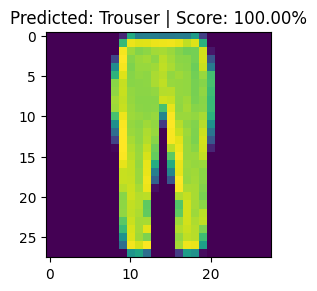

In [3]:
torch.manual_seed(0)
random_item_index = torch.randint(0, len(test_dataset), (1,)).item()
random_item = test_dataset[random_item_index]

img,_ = random_item

labelIndex = model_0(img.unsqueeze(dim=0))

highest_score_index = torch.argmax(labelIndex).item()
highest_score_percent = F.softmax(labelIndex, dim=1).squeeze()[highest_score_index].item() * 100
label = test_dataset.classes[highest_score_index]

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img.squeeze())
plt.title(f"Predicted: {label} | Score: {highest_score_percent:.2f}%")

In [4]:
with torch.inference_mode():
    parsed_test_dataset = test_dataset.data.unsqueeze(1).type(torch.float)
    logits = model_0(parsed_test_dataset)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

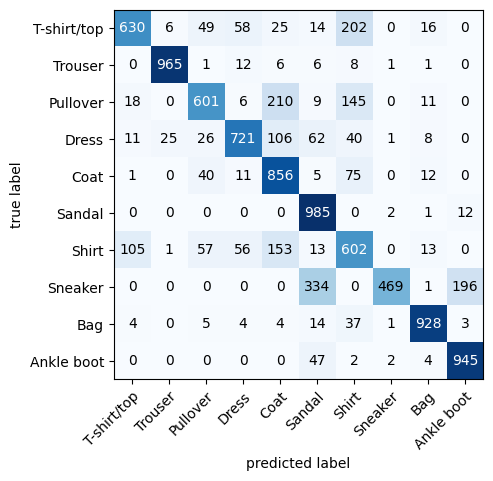

In [5]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(test_dataset.classes))

labels = logits.argmax(1)
goal_labels = test_dataset.targets

plot_confusion_matrix(confmat(labels,goal_labels).numpy(), class_names=test_dataset.classes)